In [12]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

import threading

ratings = pd.read_table('ml-1m/ratings.dat',  sep = '::', engine = 'python', header = None, names= ['UserID', 'MovieID', 'Rating', 'Timestamp'])
movies = pd.read_table('ml-1m/movies.dat',  sep = '::', engine='python', encoding = "ISO-8859-1", header = None, names= ['ID', 'Title', 'Genre'])
users = pd.read_table('ml-1m/users.dat',  sep = '::', engine='python', encoding = "ISO-8859-1", header = None, names= ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])

In [28]:
def compute_RMSE(U,M, rat_m):
    U_M = np.dot(U,M)
    diff = np.subtract(rat_m, U_M)
    RMSE = np.sqrt(np.nansum(np.square(diff))/np.count_nonzero(~np.isnan(rat_m)))
    #print(RMSE, "RMSE")
    return RMSE

kf = KFold(n_splits = 5, random_state=42, shuffle = True)
    
learning_rate = 0.005
regularization = 0.05

U_global = []
M_global = []
RMSE_test = 1000

num_iter = 75
num_factors = 10
idx = list(range(num_factors))
print(idx)

for trainid, testid in kf.split(ratings):
    train = ratings.copy()
    train.loc[testid, "Rating"] = np.nan
    u_m = train.pivot(index = "UserID", columns = "MovieID", values = "Rating")
    X = u_m.to_numpy()
    columns = list(u_m.columns)

    test = ratings.copy()
    test.loc[trainid, "Rating"] = np.nan
    u_m_test = test.pivot(index = "UserID", columns = "MovieID", values = "Rating")
    X_test = u_m_test.to_numpy()

    U = np.random.uniform(low = -0.01, high = 0.01, size=(u_m.shape[0], num_factors))
    M = np.random.uniform(low = -0.01, high = 0.01, size=(num_factors, u_m.shape[1]))
    RMSE_before = compute_RMSE(U,M, X)
    for run in range(num_iter):
        print(run)
        for i, j in np.ndindex(X.shape):
            if(np.isnan(X[i,j])):
                continue
            else:
                pred_x =np.dot(U[i,idx], M[idx, j])
                er = X[i,j] - pred_x
                U[i,idx] = [U[i,k] + learning_rate * (2*er * M[k,j] - regularization * U[i,k]) for k in range(num_factors)]
                M[idx, j] = [M[k,j] + learning_rate * (2*er * U[i,k] - regularization *M[k,j])  for k in range(num_factors)]
        RMSE_after = compute_RMSE(U,M, X)
        if RMSE_after > RMSE_before:
            break
        RMSE_before = RMSE_after
    
    test_score = compute_RMSE(U,M, X_test)
    print(test_score, "test RMSE")
    if test_score < RMSE_test:
        RMSE_test = test_score
        U_global = U
        M_global = M


    

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
0.8761954331894098 test RMSE
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
0.875083552534212 test RMSE
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
0.8722444136114228 test RMSE
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
0.8754749577029908 test

In [ ]:
ratings_matrix = np.dot(U,M)

In [32]:
pca = PCA(n_components = 2)
youmap = umap.UMAP()
tsne = TSNE()

In [34]:
mmat = M_global
umat = U_global
mmatswapped = np.swapaxes(mmat,0,1)

In [35]:
movies.rename(columns = {'ID':'MovieID'}, inplace = True)
users.rename(columns = {'ID': 'UserID'}, inplace = True)
merged = pd.merge(ratings, movies, on = 'MovieID')
merged = pd.merge(merged, users, on = 'UserID')

movielabel = merged.groupby('MovieID').first()
userlabel = merged.groupby('UserID').first()

movielabel['FirstGenre'] = movielabel['Genre']
movielabel['FirstGenre'] = movielabel['FirstGenre'].apply(lambda x: x.split('|')[0])
print(movielabel)

         UserID  Rating   Timestamp                               Title  \
MovieID                                                                   
1             1       5   978824268                    Toy Story (1995)   
2            18       2   978152541                      Jumanji (1995)   
3            62       3   977904968             Grumpier Old Men (1995)   
4           155       1   977256575            Waiting to Exhale (1995)   
5            48       3   978013996  Father of the Bride Part II (1995)   
...         ...     ...         ...                                 ...   
3948         15       3   978197734             Meet the Parents (2000)   
3949        150       4   995414747          Requiem for a Dream (2000)   
3950        151       3   998696892                    Tigerland (2000)   
3951        195       5  1033617344             Two Family House (2000)   
3952        102       3  1039274093               Contender, The (2000)   

                        

In [36]:
tsneuser = tsne.fit_transform(umat)
umapuser = youmap.fit_transform(umat)
pcauser = pca.fit_transform(umat)
tsnemovie = tsne.fit_transform(mmatswapped)
umapmovie = youmap.fit_transform(mmatswapped)
pcamovie = pca.fit_transform(mmatswapped)
print(tsneuser.shape, pcauser.shape, umapuser.shape, tsnemovie.shape, pcamovie.shape, umapmovie.shape)

(6040, 2) (6040, 2) (6040, 2) (3706, 2) (3706, 2) (3706, 2)


Text(0.5, 1.0, 'Umap Dimension Reduction')

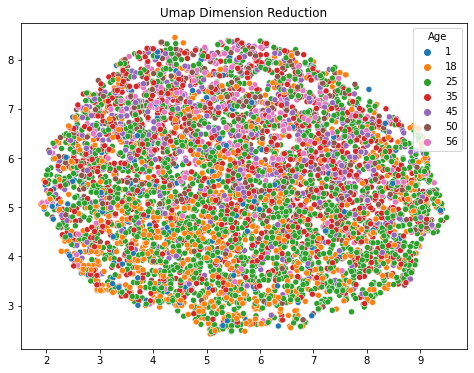

In [37]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x = umapuser[:, 0], y = umapuser[:, 1], hue = users['Age'], legend = 'full', palette = sns.color_palette(n_colors=7))
plt.title("Umap Dimension Reduction")

Text(0.5, 1.0, 'PCA Dimension Reduction')

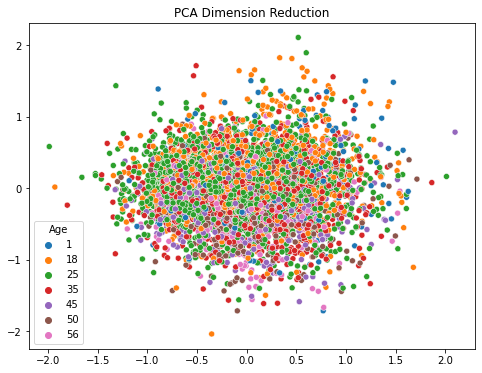

In [38]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x = pcauser[:, 0], y = pcauser[:, 1], hue = users['Age'], legend = 'full', palette = sns.color_palette(n_colors=7))
plt.title("PCA Dimension Reduction")

Text(0.5, 1.0, 'TNSE Dimension Reduction')

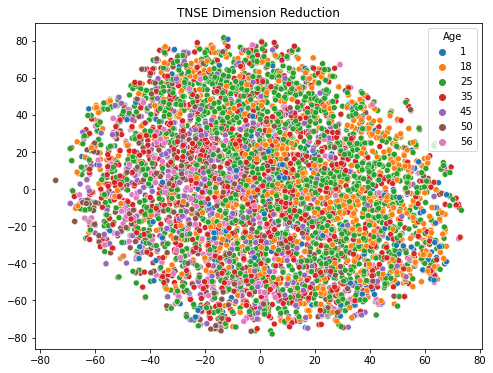

In [39]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x = tsneuser[:, 0], y = tsneuser[:, 1], hue = users['Age'], legend = 'full', palette = sns.color_palette(n_colors=7))
plt.title("TNSE Dimension Reduction")

Text(0.5, 1.0, 'TSNE Dimension Reduction')

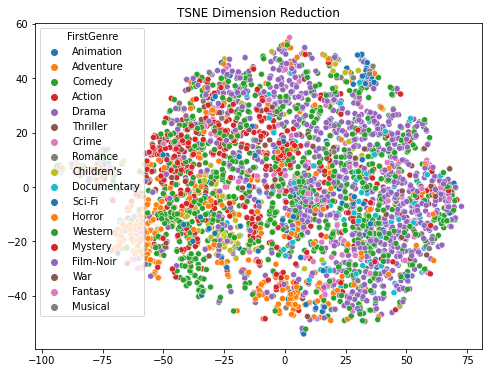

In [40]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x = tsnemovie[:, 0], y = tsnemovie[:, 1], hue = movielabel['FirstGenre'], palette = sns.color_palette(n_colors=18))
plt.title("TSNE Dimension Reduction")

Text(0.5, 1.0, 'PCA Dimension Reduction')

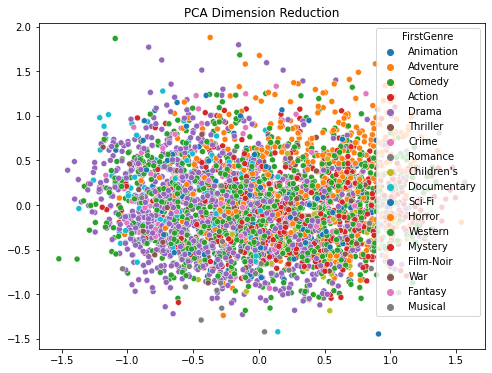

In [41]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x = pcamovie[:, 0], y = pcamovie[:, 1], hue = movielabel['FirstGenre'], palette = sns.color_palette(n_colors=18))
plt.title("PCA Dimension Reduction")

Text(0.5, 1.0, 'Umap Dimension Reduction')

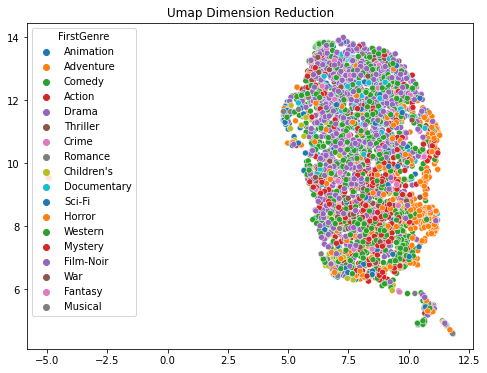

In [42]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x = umapmovie[:, 0], y = umapmovie[:, 1], hue = movielabel['FirstGenre'], palette = sns.color_palette(n_colors=18))
plt.title("Umap Dimension Reduction")

Text(0.5, 1.0, 'PCA Dimension Reduction')

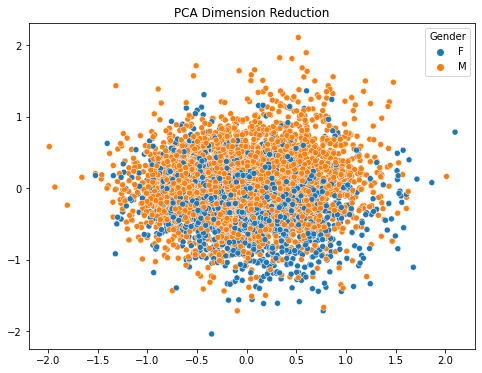

In [43]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x = pcauser[:, 0], y = pcauser[:, 1], hue = users['Gender'], legend = 'full', palette = sns.color_palette(n_colors=2))
plt.title("PCA Dimension Reduction")

Text(0.5, 1.0, 'Umap Dimension Reduction')

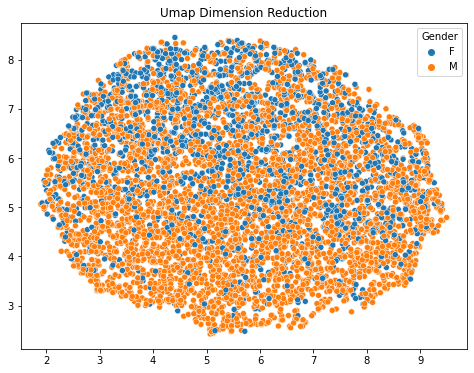

In [44]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x = umapuser[:, 0], y = umapuser[:, 1], hue = users['Gender'], legend = 'full', palette = sns.color_palette(n_colors=2))
plt.title("Umap Dimension Reduction")

Text(0.5, 1.0, 'TSNE Dimension Reduction')

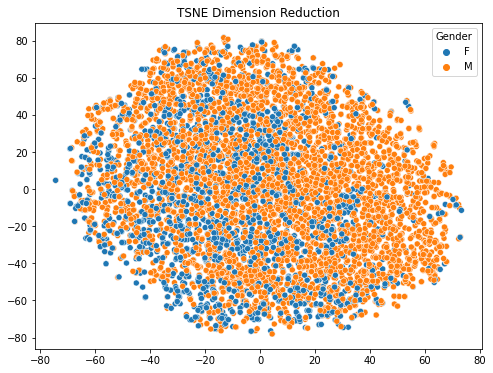

In [45]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x = tsneuser[:, 0], y = tsneuser[:, 1], hue = users['Gender'], legend = 'full', palette = sns.color_palette(n_colors=2))
plt.title("TSNE Dimension Reduction")